In [1]:
##### 使用するライブラリ・モジュールのインポート

import os
import csv
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy import signal
import cv2
from sklearn.metrics import r2_score
import pandas as pd
import math
import datetime

# 実行時間取得
updated_date = datetime.datetime.now().strftime('%Y/%m/%d %H:%M')
print("updated_date: " + updated_date)
print(type(updated_date))

updated_date: 2022/12/12 02:08
<class 'str'>


In [2]:
##### データ解析アルゴリズムパターン
print("###################  データ解析アルゴリズムパターン  ###################")

### 特徴点選出パターン
# 1: 特徴点のx,y座標それぞれの相関係数を出し，その大きい方を全特徴点で比較し，大きい順にfeature_points個取り出す．
#    解析には各特徴点の相関係数の大きかった方の座標データのみを使用する．
# 2: 特徴点のx,y座標それぞれの相関係数を出し，その平均を全特徴点で比較し，大きい順にfeature_points個取り出す．
#    解析には各特徴点の両方の座標データを使用する．
# 3: 相関〇〇以上の特徴点のみ使用する
fp_selection_pattern = 1


### 特徴点数パターン
# 1: 50個
# 2: 100個
# 3: 200個
fp_num_pattern = 1


### 特徴点検出パターン
# 1: コーナー検出
# 2: グリッドでプロット（まばらにプロット）
fp_detection_pattern = 1


### フレーム範囲パターン
# 1: trim_w = 0, trim_h = 0（全範囲使用）
# 2: trim_w = 80, trim_h = 60
# 3: trim_w = 80, trim_h = 150
frame_range_pattern = 3


### 特徴点データへのローパスフィルターパターン
# 1: かけない
# 2: ローパスフィルタをかける
lowpass_filter_pattern = 2


### 正則化パターン
# 1: 入れない
# 2: 正則化を入れる
regularization_pattern = 2


print("fp_selection_pattern: " + str(fp_selection_pattern))
print("fp_detection_pattern: " + str(fp_detection_pattern))
print("frame_range_pattern: " + str(frame_range_pattern))
print("lowpass_filter_pattern: " + str(lowpass_filter_pattern))
print("regularization_pattern: " + str(regularization_pattern))
print("#####################################################################\n")

###################  データ解析アルゴリズムパターン  ###################
fp_selection_pattern: 1
fp_detection_pattern: 1
frame_range_pattern: 3
lowpass_filter_pattern: 2
regularization_pattern: 2
#####################################################################



In [3]:
##### 解析データ・解析パス指定
print("###################  解析データ・解析パス指定  ###################")

## データ番号（ターゲットデータを一意に定めるためのもの）
# この値から自動的に、実験日、被験者、実験パターン、試行No.を抽出する．
# ※ 解析対象を変更するときは、この番号だけ変えればよい．
# data_No_start = 16
# data_No_end = 20
data_No = 20

## 解析結果の図や途中の処理データを上書きしたくないときはここで切り替える
# ※最初の解析では analysis_num = 1 を指定する
analysis_num = 1

# print("data_No_start: " + str(data_No_start))
# print("data_No_end: " + str(data_No_end))
print("data_No: " + str(data_No))
print("analysis_num: " + str(analysis_num))
print("#####################################################################\n")

###################  解析データ・解析パス指定  ###################
data_No: 20
analysis_num: 1
#####################################################################



In [4]:
##### パラメータ
print("###################  パラメータ  ###################")


### ゴニオデータ処理用 パラメータ
print("-------------  ゴニオデータ処理用パラメータ  -------------")

## 実験データ情報
# ゴニオのフレームレート
gonio_frame_rate = 100

# 周期[s]（計測パターンによって変わる）
gonio_period_list = [8, 4, 4]

# トータル波数（計測パターンによって変わる）
total_wave_num_list = [10, 15, 15]

# スタート時カット波数（計測パターンによって変わる）
cut_wave_num_list = [1, 2, 2]

# 使用波数（計測パターンによって変わる）
actual_wave_num_list = [8, 12, 12]


## ローパスフィルタ パラメータ
fp = 1.5 # 通過域端周波数[Hz] #フーリエ変換にあわせて調整
fs = 7.5 # 阻止域端周波数[Hz] # fp*5くらい
gpass = 3 # 通過域端最大損失[dB]
gstop = 40 # 阻止域端最小損失[dB]

print("gonio_frame_rate: " + str(gonio_frame_rate))
print("----------------------------------------------------------\n")


### エコーデータ処理用 パラメータ
print("-------------  エコーデータ処理用パラメータ  -------------")

# トリミングサイズ（元動画の超音波画像の部分のみに切り取る）（上下）
# 元動画サイズ：(1172, 608)
top, bottom = 40, 600


# 特徴点抽出時のフレーム範囲（フレーム全体：w:510, h:560）
if frame_range_pattern == 1:
    trim_w, trim_h = 0, 0
elif frame_range_pattern == 2:
    trim_w, trim_h = 80, 60
elif frame_range_pattern == 3:
    trim_w, trim_h = 80, 150
else:
    print("frame_range_pattern is not appropriate.")

# 特徴点数
if fp_num_pattern == 1:
    feature_num = 50
elif fp_num_pattern == 2:
    feature_num = 100
elif fp_num_pattern == 3:
    feature_num = 200
else:
    print("feature_num is not appropriate.")

## オプティカルフローパラメータ
maxCorners=1000       # 特徴点の最大数
qualityLevel=0.05     # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
minDistance=10       # 特徴点間の最小距離
blockSize=15         # 特徴点の計算に使うブロック（周辺領域）サイズ

# フレーム内へ角度情報を挿入する位置
wrist_angle_position = (40, 530)

print("trim_w, trim_h: " + str(trim_w) + ", " + str(trim_h))
print("feature_num: " + str(feature_num))
print("----------------------------------------------------------\n")


### 解析用 パラメータ
print("-------------  解析用パラメータ  -------------")

# グラフ
min_height = -80
max_height = 30

# 正則化パラメータ
# lam = 0.1
lam = 1.0

print("lam: " + str(lam))

print("----------------------------------------------------------\n")
print("#####################################################################\n")

###################  パラメータ  ###################
-------------  ゴニオデータ処理用パラメータ  -------------
gonio_frame_rate: 100
----------------------------------------------------------

-------------  エコーデータ処理用パラメータ  -------------
trim_w, trim_h: 80, 150
feature_num: 50
----------------------------------------------------------

-------------  解析用パラメータ  -------------
lam: 1.0
----------------------------------------------------------

#####################################################################



In [5]:
##### データフォルダ・データシート作成（データフォルダが存在しない場合のみ実行）
print("###################  データフォルダ・データシート作成  ###################")

current_directory = os.getcwd().replace(os.sep, "/")
print("current_directory: " + current_directory)

data_path = current_directory + "/Data"
print("data_path: " + data_path)

datasheet_all_path = data_path + "/datasheet_all" + ".csv"
print("datasheet_all_path: " + datasheet_all_path)

cols_for_all = ["Data No", "Gonio", "Echo", "Date", "Subject", "Pattern", "Trial Num", "Depth", "RMSE", "R2", "Corrcoef", "Updated Date"]


# データフォルダが存在しなければ作成
if not os.path.exists(data_path):
    os.makedirs(data_path)
    print("Data folder was successfully created.")
else:
    print("Data folder already exists.")

# datasheet_allが存在しなければ作成
if not os.path.exists(datasheet_all_path):
    df_for_all = pd.DataFrame(columns=cols_for_all)
    df_for_all.set_index("Data No", inplace=True)
    # datasheet_allへの新規書き込み
    df_for_all.to_csv(datasheet_all_path, encoding="shift_jis")
    print("datasheet_all was successfully created.")
    
else:
    print("Datasheet already exists.")
print("#####################################################################\n")

###################  データフォルダ・データシート作成  ###################
current_directory: C:/Users/katagi/Desktop/Research/UltrasoundImaging
data_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data
datasheet_all_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/datasheet_all.csv
Data folder already exists.
Datasheet already exists.
#####################################################################



In [6]:
##### datasheet_all.csv 読み込み
print("###################  datasheet_all.csv 読み込み  ###################")

# インデックスを"Data No"としたデータフレームとして読み込み
datasheet_all_df = pd.read_csv(datasheet_all_path, header=0, index_col=["Data No"], encoding='shift_jis')
datasheet_all_df = datasheet_all_df.dropna(how='all', axis=0)
print("-------------  datasheet_all_df  ---------------------")
print(datasheet_all_df)
print("------------------------------------------------------")

data_No_list = datasheet_all_df.index.tolist()
if datasheet_all_df.empty:
    data_last_No = 0
else:
    data_last_No = data_No_list[-1]
print("data_No_list: " + str(data_No_list))
print("data_last_No: " + str(data_last_No))
print("#####################################################################\n")

###################  datasheet_all.csv 読み込み  ###################
-------------  datasheet_all_df  ---------------------
                    Gonio                 Echo        Date Subject  Pattern  \
Data No                                                                       
1        202210211613.csv  20221021 161310.mp4  20221021.0  Katagi      3.0   
2        202210211616.csv  20221021 161620.mp4  20221021.0  Katagi      3.0   
3        202210211619.csv  20221021 161915.mp4  20221021.0  Katagi      3.0   
4        202210211622.csv  20221021 162244.mp4  20221021.0  Katagi      3.0   
5        202210211626.csv  20221021 162613.mp4  20221021.0  Katagi      3.0   
6        202211081334.csv  20221108 133448.mp4  20221108.0  Katagi      1.0   
7        202211081339.csv  20221108 133918.mp4  20221108.0  Katagi      1.0   
8        202211081343.csv  20221108 134301.mp4  20221108.0  Katagi      1.0   
9        202211081345.csv  20221108 134549.mp4  20221108.0  Katagi      1.0   
10       20

In [7]:
##### 指定した data_No が存在するかを確認
print("\n###################  指定した data_No が存在するかを確認  ###################")

# 指定した data_No が存在するかを確認
target_existence = data_No in datasheet_all_df.index
print("target_existence: " + str(target_existence))

# 指定した data_No が存在しない場合は，プログラム停止．
if target_existence == False:
    print("data_No: " + str(data_No) + " が存在しません．")
    print("datasheet_all.csvに新しく書き込む場合は，writeDataToDatasheetAllファイルを実行してください．")
    raise Exception("data_No doesn't exist.")
print("#####################################################################\n")


###################  指定した data_No が存在するかを確認  ###################
target_existence: True
#####################################################################



In [8]:
##### 指定したdata_Noのデータ（ターゲットデータ）のみを取得
print("###################  指定したdata_Noのデータ（ターゲットデータ）のみを取得  ###################")

target_df = datasheet_all_df.loc[data_No:data_No].copy()

print('-------  target_df  -----------')
print(target_df)
print('-------------------------------')
print("#####################################################################\n")

###################  指定したdata_Noのデータ（ターゲットデータ）のみを取得  ###################
-------  target_df  -----------
                    Gonio                 Echo        Date Subject  Pattern  \
Data No                                                                       
20       202212061627.csv  20221206 162753.mp4  20221204.0  Katagi      1.0   

         Trial Num  Depth  RMSE  R2  Corrcoef      Updated Date  
Data No                                                          
20             5.0   30.0   NaN NaN       NaN  2022/12/07 18:22  
-------------------------------
#####################################################################



In [9]:
##### 取得したターゲットデータから Data_PATH(Gonio, Echo), Data_INFO(date, subject, pattern) , trial_num を読み込む
print("###################  取得したターゲットデータから Data_PATH(Gonio, Echo), Data_INFO(date, subject, pattern) , trial_num を読み込む  ###################")

print('--------  Target Data Information  --------------')

## DATA_PATH
print("\nDATA_PATH: ")

# ゴニオ（関節角度）データファイル名
gonio_file = target_df.loc[data_No ,"Gonio"]

# エコー動画ファイル名
echo_file = target_df.loc[data_No ,"Echo"]

print("gonio_file      : " + str(gonio_file))
print("echo_file       : " + str(echo_file))


## DATA_INFO
print("\nDATA_INFO: ")

## INFO
# 実験日
date = str(int(target_df.loc[data_No, "Date"]))

# 被験者
subject = target_df.loc[data_No, "Subject"]

# 実験パターン
pattern = int(target_df.loc[data_No, "Pattern"])

# 試行番号
trial_num = int(target_df.loc[data_No, "Trial Num"])

# 深度
depth = int(target_df.loc[data_No, "Depth"])

print("date            : " + date)
print("subject         : " + subject)
print("pattern         : " + str(pattern))
print("trial_num       : " + str(trial_num))
print("depth           : " + str(depth))

print('-------------------------------------------------')

##### 深度によって変化するパラメータ
depth_param = {20 : [73, [70, 1100]], 30 : [62, [85, 1085]], 40 : [54, [200, 970]], 50 : [48, [280, 890]], 60 : [43, [325, 845]]}

# ※ ↓ 深度によってフレームレートとトリミングする範囲が変わる
# |---------------------------------------------------------------------------------|
# | Depth:         |     20     |      30    |      40    |      50    |      60    |
# |---------------------------------------------------------------------------------|
# | Frame Rate:    |     73     |      62    |      54    |      48    |      43    |
# | Triming Range: | [70, 1100] | [85, 1085] | [200, 970] | [280, 890] | [325, 845] |
# |---------------------------------------------------------------------------------|


## depthごとのframe_rate と triming range
# 動画のフレームレート
echo_frame_rate = depth_param[depth][0]
# トリミング範囲（左右）
left, right = depth_param[depth][1][0], depth_param[depth][1][1]

print("echo_frame_rate: " + str(echo_frame_rate))
print("left, right: " + str(left) + ", " + str(right))
print("#####################################################################\n")

###################  取得したターゲットデータから Data_PATH(Gonio, Echo), Data_INFO(date, subject, pattern) , trial_num を読み込む  ###################
--------  Target Data Information  --------------

DATA_PATH: 
gonio_file      : 202212061627.csv
echo_file       : 20221206 162753.mp4

DATA_INFO: 
date            : 20221204
subject         : Katagi
pattern         : 1
trial_num       : 5
depth           : 30
-------------------------------------------------
echo_frame_rate: 62
left, right: 85, 1085
#####################################################################



In [10]:
##### data_per_infoパス指定
print("###################  data_per_infoパス指定  ###################")

info_str = date + "_" + subject + "_pattern" + str(pattern)
data_per_info_path = data_path + "/" + info_str
print("data_per_info_path: " + data_per_info_path)

# data_per_info フォルダが存在しなければ実行停止
if not os.path.exists(data_per_info_path):
    print("該当するフォルダが存在しません．")
    raise Exception("Data doesn't exist in this folder.")
print("#####################################################################\n")

###################  data_per_infoパス指定  ###################
data_per_info_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221204_Katagi_pattern1
#####################################################################



In [11]:
##### 解析パス設定
print("###################  解析パス設定  ###################")
analysis_path = data_per_info_path + "/Analysis" + str(analysis_num)
print("analysis_path: " + str(analysis_path))

## 最初の解析の時には，以下のフォルダ・データシートを作成
# data_per_info フォルダ直下にdatasheet_per_infoを作成
datasheet_per_info_path = data_per_info_path + "/datasheet_" + info_str + ".csv"
cols_per_info = ["Per Info No", "Data No", "Gonio", "Echo", "Date", "Subject", "Pattern", "Trial Num", "Depth", "Analysis Num", 
              "FP Selection Pattern", "FP Num Pattern", "FP Detection Pattern", "Frame Range Pattern", "Lowpass Filter Pattern", "Regularization Patten", 
              "RMSE", "R2", "Corrcoef", "Updated Date"]
if not os.path.exists(datasheet_per_info_path):
    df_per_info = pd.DataFrame(columns=cols_per_info)
    df_per_info.set_index("Per Info No", inplace=True)
    # datasheet_per_infoへの新規書き込み
    df_per_info.to_csv(datasheet_per_info_path, encoding="shift_jis")
    print("datasheet_" + info_str + " was successfully created.")

# EchoData フォルダ直下に新しいフォルダを作成
preprocessed_movie_path = data_per_info_path + "/EchoData/PreprocessedMovie"
if not os.path.exists(preprocessed_movie_path):
    os.makedirs(preprocessed_movie_path)

# GonioData フォルダ直下に新しいフォルダを作成
preprocessed_gonio_path = data_per_info_path + "/GonioData/PreprocessedGonio"
if not os.path.exists(preprocessed_gonio_path):
    os.makedirs(preprocessed_gonio_path)
print("#####################################################################\n")

###################  解析パス設定  ###################
analysis_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221204_Katagi_pattern1/Analysis1
#####################################################################



In [12]:
##### 新しい解析パスを指定したとき（analysis_numを変えた時）に解析フォルダとその直下に必要なフォルダを作成
print("###################  必要なフォルダを作成  ###################")

if not os.path.exists(analysis_path):

    # analysis_path フォルダを作成
    os.makedirs(analysis_path)

    # analysis_path フォルダ直下に新しいフォルダを作成
    processed_data_path = analysis_path + "/ProcessedData"
    results_path = analysis_path + "/Results"
    os.makedirs(processed_data_path)
    os.makedirs(results_path)

    # ProcessedData フォルダ直下に新しいフォルダを作成
    echo_processed_path = processed_data_path + "/EchoProcessed"
    gonio_processed_path = processed_data_path + "/GonioProcessed"
    os.makedirs(echo_processed_path)
    os.makedirs(gonio_processed_path)

    ## EchoProcessed フォルダ直下に新しいフォルダを作成
    # 生データとフィルターをかけた後のデータの比較グラフを保存する場所
    echo_raw_vs_filtered_path = echo_processed_path + "/EchoRawVSFiltered"
    # フィルターをかけた後の特徴点データを保存する場所
    filtered_fp_path = echo_processed_path + "/FilteredFP"
    # 選出した特徴点データ（解析用）を保存する場所
    fp_for_analysis_path = echo_processed_path + "/FPForAnalysis"
    # 選出した特徴点データ（描画用）を保存する場所
    fp_for_visualize_path = echo_processed_path + "/FPForVisualize"
    # オプティカルフローの動画を保存する場所
    opticalflow_movie_path = echo_processed_path + "/OpticalflowMovie"

    os.makedirs(echo_raw_vs_filtered_path)
    os.makedirs(filtered_fp_path)
    os.makedirs(fp_for_analysis_path)
    os.makedirs(fp_for_visualize_path)
    os.makedirs(opticalflow_movie_path)


    ## GonioProcessed フォルダ直下に新しいフォルダを作成
    # フィルターをかけた後の関節角度データを保存する場所
    filtered_theta_path = gonio_processed_path + "/FilteredTheta"
    # 生データとフィルターをかけた後のデータの比較グラフを保存する場所
    gonio_raw_vs_filtered_path = gonio_processed_path + "/GonioRawVSFiltered"

    os.makedirs(filtered_theta_path)
    os.makedirs(gonio_raw_vs_filtered_path)


    ## Results フォルダ直下に新しいフォルダ・結果用csvファイルを作成
    # 関節角度の実測値と推定値の比較グラフを保存する場所
    angle_estimation_path = results_path + "/AngleEstimation"
    # 特徴点の挙動を示す図を保存する場所
    fp_behavior_path = results_path + "/FPBehavior"

    os.makedirs(angle_estimation_path)
    os.makedirs(fp_behavior_path)

    print("All folders were successfully created.")

else:
    print(analysis_path + " folder already exists.")
print("#####################################################################\n")

###################  必要なフォルダを作成  ###################
C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221204_Katagi_pattern1/Analysis1 folder already exists.
#####################################################################



In [13]:
##### datasheet_per_info.csv 読み込み
print("###################  datasheet_per_info.csv 読み込み  ###################")

# インデックスを"No"としたデータフレームとして読み込み
datasheet_per_info_df = pd.read_csv(datasheet_per_info_path, header=0, index_col=["Per Info No"], encoding='shift_jis')
datasheet_per_info_df = datasheet_per_info_df.dropna(how='all', axis=0)
print("-------------  datasheet_per_info_df  ---------------------")
print(datasheet_per_info_df)
print("-----------------------------------------------------------")

per_info_No_list = datasheet_per_info_df.index.tolist()
if datasheet_per_info_df.empty:
    last_per_info_No = 0
else:
    last_per_info_No = per_info_No_list[-1]
print("per_info_No_list: " + str(per_info_No_list))
print("last_per_info_No: " + str(last_per_info_No))
print("#####################################################################\n")

###################  datasheet_per_info.csv 読み込み  ###################
-------------  datasheet_per_info_df  ---------------------
             Data No             Gonio                 Echo      Date Subject  \
Per Info No                                                                     
1                 16  202212061614.csv  20221206 161438.mp4  20221204  Katagi   
1                 16  202212061614.csv  20221206 161438.mp4  20221204  Katagi   
1                 16  202212061614.csv  20221206 161438.mp4  20221204  Katagi   
2                 17  202212061617.csv  20221206 161753.mp4  20221204  Katagi   
3                 18  202212061621.csv  20221206 162112.mp4  20221204  Katagi   
4                 19  202212061624.csv  20221206 162430.mp4  20221204  Katagi   

             Pattern  Trial Num  Depth  Analysis Num  FP Selection Pattern  \
Per Info No                                                                  
1                  1          1     30             1             

In [14]:
##### datasheet_per_info_dfから該当するデータを取得（data_No, date, subject, pattern, trial_num, depth, analysis_numが一致）
print("###################  datasheet_per_info_dfから該当するデータを取得  ###################")

target_per_info_df = datasheet_per_info_df[
  (datasheet_per_info_df["Data No"]==data_No) & (datasheet_per_info_df["Date"]==float(date)) & (datasheet_per_info_df["Subject"]==subject) 
  & (datasheet_per_info_df["Pattern"]==pattern) & (datasheet_per_info_df["Trial Num"]==trial_num) & (datasheet_per_info_df["Depth"]==depth) 
  & (datasheet_per_info_df["Analysis Num"]==analysis_num)].copy()

print('-------  target_per_info_df  -----------')
print(target_per_info_df)
print('----------------------------------------')

# インデックス"per_info_No"を取得
if target_per_info_df.empty:
    per_info_No = last_per_info_No + 1
else:
    per_info_No = target_per_info_df.index.tolist()[0]
print("per_info_No: " + str(per_info_No))
print("#####################################################################\n")

###################  datasheet_per_info_dfから該当するデータを取得  ###################
-------  target_per_info_df  -----------
Empty DataFrame
Columns: [Data No, Gonio, Echo, Date, Subject, Pattern, Trial Num, Depth, Analysis Num, FP Selection Pattern, FP Num Pattern, FP Detection Pattern, Frame Range Pattern, Lowpass Filter Pattern, Regularization Patten, RMSE, R2, Corrcoef, Updated Date]
Index: []
----------------------------------------
per_info_No: 5
#####################################################################



In [15]:
##### パラメータ（データ取得後にわかる情報）
print("###################  パラメータ（データ取得後にわかる情報）  ###################")


### ゴニオデータ処理用 パラメータ

# 周期
gonio_period = gonio_period_list[pattern - 1]

# トータル波数
total_wave_num = total_wave_num_list[pattern - 1]

# スタート時カット波数
cut_wave_num = cut_wave_num_list[pattern - 1]

# 使用波数
actual_wave_num = actual_wave_num_list[pattern - 1]


# データ抽出開始時間[s]
start_time = gonio_period * cut_wave_num

# 使用時間[s]
total_time = gonio_period * actual_wave_num

# データ抽出終了時刻[s]
end_time = start_time + total_time


# csvファイル内の目的データの開始位置
start_row = gonio_frame_rate * start_time
end_row = gonio_frame_rate * end_time - 1
target_column = 1


numOfData = echo_frame_rate * total_time
interpolate_rate = gonio_frame_rate * echo_frame_rate

time = np.linspace(0, total_time, numOfData)


print("gonio_period: " + str(gonio_period))
print("total_wave_num: " + str(total_wave_num))
print("cut_wave_num: " + str(cut_wave_num))
print("actual_wave_num: " + str(actual_wave_num))

print("start_time: " + str(start_time))
print("total_time: " + str(total_time))
print("end_time: " + str(end_time))

print("start_row: " + str(start_row))
print("end_row: " + str(end_row))

print("numOfData: " + str(numOfData))
print("interpolate_rate: " + str(interpolate_rate))
print("time: ")
print(time, time.shape)
print("#####################################################################\n")

###################  パラメータ（データ取得後にわかる情報）  ###################
gonio_period: 8
total_wave_num: 10
cut_wave_num: 1
actual_wave_num: 8
start_time: 8
total_time: 64
end_time: 72
start_row: 800
end_row: 7199
numOfData: 3968
interpolate_rate: 6200
time: 
[0.00000000e+00 1.61330981e-02 3.22661961e-02 ... 6.39677338e+01
 6.39838669e+01 6.40000000e+01] (3968,)
#####################################################################



In [16]:
print("################################################################")
print("###################  ゴニオデータの処理  ########################")
print("################################################################")

################################################################
###################  ゴニオデータの処理  ########################
################################################################


In [17]:
##### ゴニオデータ関連パス設定
print("###################  ゴニオデータ関連パス設定  ###################")

print("Target Gonio Data: " + gonio_file)

# データ読み込み用パス
# target_gonio_path = data_per_info_path + "/GonioData/" + gonio_file
target_gonio_file_path = data_per_info_path + "/GonioData/" + gonio_file

# データ前処理用パス
preprocessed_gonio_file_path = data_per_info_path + "/GonioData/PreprocessedGonio/" + gonio_file

# データ保存用パス
gonio_processed_path = analysis_path + "/ProcessedData/GonioProcessed"
filtered_theta_file_path = gonio_processed_path + "/FilteredTheta/" + gonio_file
gonio_raw_vs_filtered_file_path = gonio_processed_path + "/GonioRawVSFiltered/" + gonio_file.split(".")[0] + ".png"

print("#####################################################################\n")

###################  ゴニオデータ関連パス設定  ###################
Target Gonio Data: 202212061627.csv
#####################################################################



In [18]:
##### 生データ読み込み
print("###################  生データ読み込み  ###################")

# preprocessed_gonio_file_path が存在しない場合実行
if not os.path.exists(preprocessed_gonio_file_path):
    gonio_raw = pd.read_csv(target_gonio_file_path, header=0, usecols=['Time', 'Gonio'])
    print(gonio_raw)

    print("------------------------------------")
    gonio_raw['Time'] = (gonio_raw['Time'] // 10) * 10
    print(gonio_raw)
    print("gonio_raw length: " + str(len(gonio_raw)))

else:
    print("preprocessed_gonio_path already exists.")
print("#####################################################################\n")

###################  生データ読み込み  ###################
            Time      Gonio
0        23.1174   6.273193
1        32.9499   6.465454
2        42.9087   6.218262
3        52.8878   7.619019
4        62.8995   6.190796
...          ...        ...
7865  79942.8700 -12.376100
7866  79952.8800 -10.426030
7867  79962.8600 -11.002810
7868  79972.9000  -8.448486
7869  79982.8800 -11.332400

[7870 rows x 2 columns]
------------------------------------
         Time      Gonio
0        20.0   6.273193
1        30.0   6.465454
2        40.0   6.218262
3        50.0   7.619019
4        60.0   6.190796
...       ...        ...
7865  79940.0 -12.376100
7866  79950.0 -10.426030
7867  79960.0 -11.002810
7868  79970.0  -8.448486
7869  79980.0 -11.332400

[7870 rows x 2 columns]
gonio_raw length: 7870
#####################################################################



In [19]:
##### ゴニオデータ補間
print("###################  ゴニオデータ補間  ###################")
# preprocessed_gonio_file_path が存在しない場合のみ実行
if not os.path.exists(preprocessed_gonio_file_path):
    
    gonio_col = ['Time', 'Gonio']
    gonio_rearranged_df = pd.DataFrame(columns=gonio_col)
    # print(gonio_rearranged_df)

    for row in gonio_raw.itertuples():
        # 計測開始時のラグを補完
        if row.Index == 0:
            start_modify_num = int(row.Time / 10) - 1
            if start_modify_num >= 1:
                for i in range(start_modify_num):
                    new_time = (i+1) * 10.0
                    new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [row.Gonio]})
                    gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)

        # データが飛んでいるときに補間
        if row.Index >= 1:
            time_dif = row.Time - pre_time
            if time_dif == 0:
                continue
            if time_dif >= 20.0:
#                 print("----------------------------------")
#                 print("time_dif: " + str(time_dif))
#                 print("pre_time: " + str(pre_time))
#                 print("current_time: " + str(row.Time))
#                 print("pre_gonio: " + str(pre_gonio))
#                 print("current_gonio: " + str(row.Gonio))
                gonio_dif = row.Gonio - pre_gonio
                modify_num = int(time_dif / 10) - 1
                devide_num = modify_num + 1
                for i in range(modify_num):
                    new_time = pre_time + (time_dif) * ((i+1) / devide_num)
                    new_gonio = pre_gonio + (gonio_dif) * ((i+1) / devide_num)
                    new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [new_gonio]})
                    gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)
#                     print("---------------------------")
#                     print("new_time: " + str(new_time))
#                     print("new_gonio: " + str(new_gonio))
#                     print("---------------------------")

#                 print("----------------------------------")

#             if row.Index == 120:
#                 break

        new_df = pd.DataFrame(data={'Time': [row.Time], 'Gonio': [row.Gonio]})
        gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)
        # データ補間のために直前のデータとして保持
        pre_time = row.Time
        pre_gonio = row.Gonio

    # 計測終了時のデータ補間
    last_time = float(gonio_period * total_wave_num * 1000)
    print("last_time: " + str(last_time))
    last_time_dif = last_time - pre_time
    last_modify_num = int(last_time_dif / 10)
    if last_modify_num >= 1:
        for i in range(last_modify_num):
            new_time = pre_time + (i+1) * 10.0
            new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [row.Gonio]})
            gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)

    print("gonio_rearranged_df: ")
    print(gonio_rearranged_df)
    print(len(gonio_rearranged_df))
    
    
    ### ゴニオ補間データの保存
    gonio_rearranged_df.to_csv(preprocessed_gonio_file_path, encoding="shift_jis", index=False)
    print("preprocessed_gonio file was successfully created.")

else:
    print("preprocessed_gonio_path already exists.")
print("#####################################################################\n")

###################  ゴニオデータ補間  ###################
last_time: 80000.0
gonio_rearranged_df: 
         Time      Gonio
0        10.0   6.273193
1        20.0   6.273193
2        30.0   6.465454
3        40.0   6.218262
4        50.0   7.619019
...       ...        ...
7995  79960.0 -11.002810
7996  79970.0  -8.448486
7997  79980.0 -11.332400
7998  79990.0 -11.332400
7999  80000.0 -11.332400

[8000 rows x 2 columns]
8000
preprocessed_gonio file was successfully created.
#####################################################################



In [20]:
##### ゴニオ補間データの読み込み
print("###################  ゴニオ補間データの読み込み  ###################")

preprocessed_gonio_data = pd.read_csv(preprocessed_gonio_file_path, header=0, encoding='shift_jis')

preprocessed_gonio_data = preprocessed_gonio_data.loc[start_row:end_row, 'Gonio'].to_numpy()
print("preprocessed_gonio_data: " + str(preprocessed_gonio_data))
print(preprocessed_gonio_data.shape)
print("#####################################################################\n")

###################  ゴニオ補間データの読み込み  ###################
preprocessed_gonio_data: [ -2.598267  -2.543335  -2.515869 ... -10.86548  -10.86548  -10.2887  ]
(6400,)
#####################################################################



In [21]:
##### フレームレート調整
print("###################  フレームレート調整  ###################")
# gonioとechoのフレームレートを合わせる
# gonioデータを補完(interpolate)しエコーデータにあわせてリサンプリングする
# 参考ページ: https://watlab-blog.com/2019/09/19/resampling/

t0 = 0    # 初期時間[s]
dt = 1/gonio_frame_rate  # 時間刻み[s] 1/100
t = np.arange(t0, total_time, dt)

interpolate_num = interpolate_rate * total_time
t_interpolate = np.linspace(t0, total_time - dt, interpolate_num)

# 補間
f = interpolate.interp1d(t, preprocessed_gonio_data, kind="cubic")
interpolated_theta = f(t_interpolate)

# リサンプリング
resampled_theta = list()
for i in range(len(interpolated_theta)):
    if i % gonio_frame_rate == 0:
        resampled_theta.append(interpolated_theta[i])
    if (len(resampled_theta)) >= numOfData:
        break

resampled_theta = np.array(resampled_theta).astype(float)[:]


print("t: " + str(t) + str(t.shape))
print("interpolate_num: " + str(interpolate_num))
print("t_interpolate: ")
print(t_interpolate, t_interpolate.shape)
print("interpolated_theta: ")
print(interpolated_theta, interpolated_theta.shape)
print("resampled_theta: ")
print(resampled_theta, resampled_theta.shape)
print("#####################################################################\n")

###################  フレームレート調整  ###################
t: [0.000e+00 1.000e-02 2.000e-02 ... 6.397e+01 6.398e+01 6.399e+01](6400,)
interpolate_num: 396800
t_interpolate: 
[0.00000000e+00 1.61265527e-04 3.22531055e-04 ... 6.39896775e+01
 6.39898387e+01 6.39900000e+01] (396800,)
interpolated_theta: 
[ -2.598267    -2.60417033  -2.60973904 ... -10.31872508 -10.3038178
 -10.2887    ] (396800,)
resampled_theta: 
[ -2.598267    -2.43805702  -2.99330161 ... -11.4712809  -11.30898647
 -10.91974592] (3968,)
#####################################################################



In [22]:
##### 正規化
print("###################  正規化  ###################")
# NumPyで配列の正規化(normalize)、標準化する方法
# 参考ページ: https://deepage.net/features/numpy-normalize.html

theta_mean = resampled_theta.mean(axis=None, keepdims=True)
theta_std = np.std(resampled_theta, axis=None, keepdims=True)

theta_zscore = (resampled_theta - theta_mean) / theta_std

print("theta_mean: " + str(theta_mean))
print("theta_std: " + str(theta_std))
print("theta_zscore: ")
print(theta_zscore, theta_zscore.shape)
print("#####################################################################\n")

###################  正規化  ###################
theta_mean: [-29.592513]
theta_std: [20.12715852]
theta_zscore: 
[1.34118514 1.34914503 1.3215582  ... 0.90033733 0.90840078 0.92773985] (3968,)
#####################################################################



In [23]:
##### ローパスフィルタ
print("###################  ローパスフィルタ  ###################")
# 角度情報の加工
# 参考ページ: Pythonによるデータ処理4 ～ フィルタ処理
# https://atatat.hatenablog.com/entry/data_proc_python4
# 参考ページ: PythonのSciPyでローパスフィルタをかける！
# https://watlab-blog.com/2019/04/30/scipy-lowpass/

select_normarize_joint = 2
#1:正規化しない，2:正規化する

if select_normarize_joint == 1:
    # 正規化しない
    theta_before_low = resampled_theta
    print("正規化なし")
    print(theta_before_low.shape)

if select_normarize_joint == 2:
    #正規化する
    theta_before_low = theta_zscore
    print("正規化する")
    print(theta_before_low.shape)

fn = gonio_frame_rate / 2   #ナイキスト周波数
wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算

theta_lowpass = signal.filtfilt(b, a, theta_before_low)                  #信号に対してフィルタをかける

print("fn: " + str(fn))
print("wp: " + str(wp))
print("ws: " + str(ws))
print("N: " + str(N))
print("Wn: " + str(Wn))
print("b: " + str(b))
print("a: " + str(a))
print("theta_lowpass: ")
print(theta_lowpass, theta_lowpass.shape)
print("#####################################################################\n")

###################  ローパスフィルタ  ###################
正規化する
(3968,)
fn: 50.0
wp: 0.03
ws: 0.15
N: 3
Wn: 0.03002371892387966
b: [9.56622667e-05 2.86986800e-04 2.86986800e-04 9.56622667e-05]
a: [ 1.         -2.81142481  2.64021284 -0.82802273]
theta_lowpass: 
[1.33748309 1.34219096 1.34690571 ... 0.76053191 0.76357821 0.7661249 ] (3968,)
#####################################################################



###################  図で確認  ###################
x: 
(3968,)
y1: 
(3968,)
y2: 
(3968,)
theta_before_low and theta_lowpass: 


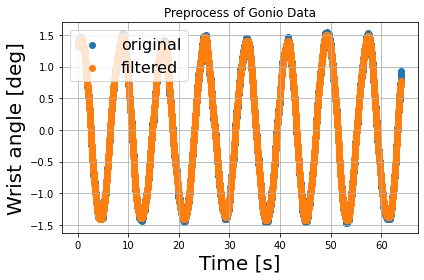

resampled_theta: 


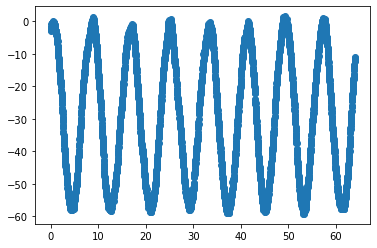

theta_zscore: 


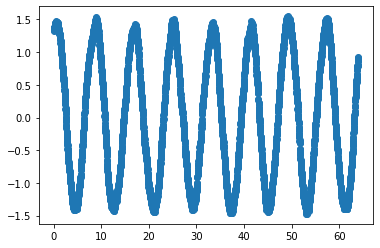

#####################################################################



In [24]:
##### 図で確認
print("###################  図で確認  ###################")
x = time
y1 = theta_before_low
y2 = theta_lowpass
print("x: ")
print(x.shape)
print("y1: ")
print(y1.shape)
print("y2: ")
print(y2.shape)

print("theta_before_low and theta_lowpass: ")
fig = plt.figure()
plt.title("Preprocess of Gonio Data")
plt.scatter(x, y1, label='original')
plt.scatter(x, y2, label='filtered')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

print("resampled_theta: ")
plt.scatter(time, resampled_theta, label='original')
plt.show()

print("theta_zscore: ")
plt.scatter(time, theta_zscore, label='normalized')
plt.show()
print("#####################################################################\n")


In [25]:
##### 処理データ・図の保存
print("###################  処理データ・図の保存  ###################")
theta = theta_lowpass

print("time: ")
print(time, time.shape)
print("theta: ")
print(theta, theta.shape)

# 前処理したゴニオデータを保存
with open(filtered_theta_file_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Time", "Gonio"])
    for i in range(theta.shape[0]):
        writer.writerow([time[i], theta[i]])
    f.close()
    
# フィルターをかける前後のデータの比較グラフを保存
fig.savefig(gonio_raw_vs_filtered_file_path)
print("#####################################################################\n")

###################  処理データ・図の保存  ###################
time: 
[0.00000000e+00 1.61330981e-02 3.22661961e-02 ... 6.39677338e+01
 6.39838669e+01 6.40000000e+01] (3968,)
theta: 
[1.33748309 1.34219096 1.34690571 ... 0.76053191 0.76357821 0.7661249 ] (3968,)
#####################################################################



In [26]:
print("################################################################")
print("###################  エコーデータの処理  ########################")
print("################################################################")

################################################################
###################  エコーデータの処理  ########################
################################################################


In [27]:
##### エコーデータ関連パス設定
print("###################  エコーデータ関連パス設定  ###################")
print("Target Echo Data: " + echo_file)

# データ読み込み用パス
echo_path = data_per_info_path + "/EchoData"
target_echo_path = echo_path + "/" + echo_file

# データ前処理用パス
preprocessed_movie_path = echo_path + "/PreprocessedMovie/" + echo_file

# データ保存用パス
echo_processed_path = analysis_path + "/ProcessedData/EchoProcessed"
echo_raw_vs_filtered_file_path = echo_processed_path + "/EchoRawVSFiltered/" + echo_file.split(".")[0] + ".png"
filtered_fp_file_path = echo_processed_path + "/FilteredFP/" + echo_file.split(".")[0] + ".csv"
fp_for_analysis_file_path = echo_processed_path + "/FPForAnalysis/" + echo_file.split(".")[0] + ".csv"
fp_for_visualize_file_path = echo_processed_path + "/FPForVisualize/" + echo_file.split(".")[0] + ".csv"
opticalflow_movie_file_path = echo_processed_path + "/OpticalflowMovie/" + echo_file

print("target_echo_path: " + str(target_echo_path))
print("#####################################################################\n")

###################  エコーデータ関連パス設定  ###################
Target Echo Data: 20221206 162753.mp4
target_echo_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221204_Katagi_pattern1/EchoData/20221206 162753.mp4
#####################################################################



In [28]:
##### 動画の前処理（実験データごとに最初の1回だけ実行する）
print("###################  動画の前処理  ###################")
# 1. 動画時間を計測時間に合わせる（必要なフレーム数だけを保存）
# 2. 画像内の不要な部分を削る(スクリーン中のエコー部分のみ)

# preprocessed_movie_pathが存在しない場合のみこのセルを実行
if not os.path.exists(preprocessed_movie_path):
    
    # 動画取得
    video = cv2.VideoCapture(target_echo_path)

    # 動画情報
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS))   # 73, 62, 54, 48, or 43
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # フレームレート確認
    print("--Before Processing--")
    print("WIDTH: " + str(width) + ", HEIGHT: " + str(height))
    print("FRAME RATE: " + str(frame_rate) + ",\nFRAME COUNT: " + str(frame_count) + "\n")

    # 必要なフレームのみ取り出す
    start_frame = start_time * frame_rate
    end_frame = end_time * frame_rate

    # 保存の準備
    fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    new_size = (right - left, bottom - top)
    save = cv2.VideoWriter(preprocessed_movie_path, fmt, frame_rate, new_size)

    for i in range(end_frame):    # 1.の処理
        ret, frame = video.read()
        if ret == False:
            break
        if i < start_frame:
            continue

        frame = frame[top:bottom, left:right]   # 2.の処理
        frame = cv2.resize(frame, new_size)
        cv2.imshow("check frame", frame)
        key = cv2.waitKey(10)
        # qキーが押されたら途中終了
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
        save.write(frame)

    save.release()
    video.release()
    cv2.destroyAllWindows()

    processed_video = cv2.VideoCapture(preprocessed_movie_path)
    # 動画情報
    width = int(processed_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(processed_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(processed_video.get(cv2.CAP_PROP_FPS))   # 73, 62, 54, 48, or 43
    frame_count = int(processed_video.get(cv2.CAP_PROP_FRAME_COUNT))
    processed_video.release()
    print("--After Processing--")
    print("WIDTH: " + str(width) + ", HEIGHT: " + str(height))
    print("FRAME RATE: " + str(frame_rate) + ",\nFRAME COUNT: " + str(frame_count) + "\n")

    print("Preprocessing is done")
else:
    print("Processed Movie already Exists")
print("#####################################################################\n")

###################  動画の前処理  ###################
--Before Processing--
WIDTH: 1172, HEIGHT: 608
FRAME RATE: 62,
FRAME COUNT: 5205

--After Processing--
WIDTH: 1000, HEIGHT: 560
FRAME RATE: 62,
FRAME COUNT: 3968

Preprocessing is done
#####################################################################



In [29]:
##### 特徴点抽出
print("###################  特徴点抽出  ###################")

# 動画取得
video = cv2.VideoCapture(preprocessed_movie_path)

# # 動画情報
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_rate = int(video.get(cv2.CAP_PROP_FPS)) # 73, 62, 54, 48, or 43
size = (width, height)  # (right - left, 560)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print("FRAME COUNT: " + str(frame_count) + ",\nWIDTH: " + str(width) + ", HEIGHT: " + str(height) + "\n")

# 最初のフレームを取得してグレースケール変換
ret, frame = video.read()
frame_pre = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# 特徴点抽出パターン
if fp_detection_pattern == 1:
    ## パターン⓵Shi-Tomasiのコーナー検出
    
    # Shi-Tomasi法のパラメータ（コーナー：物体の角を特徴点として検出）
    ft_params = dict(maxCorners=maxCorners,       # 特徴点の最大数
    qualityLevel=qualityLevel,    # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
    minDistance=minDistance,       # 特徴点間の最小距離
    blockSize=blockSize)         # 特徴点の計算に使うブロック（周辺領域）サイズ
    
    # 特徴点検出範囲を限定
    frame_pre_first = frame_pre[trim_h : height - trim_h, trim_w : width - trim_w]

    # Shi-Tomasi法で特徴点の検出
    feature_pre = cv2.goodFeaturesToTrack(frame_pre_first, mask=None, **ft_params)
    print(feature_pre.shape)
    print(feature_pre)

    # 特徴点座標を元のフレームに合わせる
    for v in feature_pre:
        v[0][0] += trim_w
        v[0][1] += trim_h

elif fp_detection_pattern == 2:
    ## パターン⓶まばらにプロット
    feature_pre = 1
else:
    print("fp_detection_pattern is not appropriate.")

print("#####################################################################\n")

###################  特徴点抽出  ###################
FRAME COUNT: 3968,
WIDTH: 1000, HEIGHT: 560

(431, 1, 2)
[[[ 14.  87.]]

 [[804. 187.]]

 [[311. 135.]]

 [[446. 190.]]

 [[ 86.  95.]]

 [[409. 158.]]

 [[734.  67.]]

 [[ 81.  30.]]

 [[683. 132.]]

 [[437. 181.]]

 [[721. 131.]]

 [[376. 195.]]

 [[272. 185.]]

 [[782.  54.]]

 [[399. 190.]]

 [[195. 132.]]

 [[364. 190.]]

 [[393. 174.]]

 [[223. 140.]]

 [[470.  29.]]

 [[419. 190.]]

 [[790.  45.]]

 [[420. 153.]]

 [[345.  41.]]

 [[326. 182.]]

 [[355. 175.]]

 [[ 70.  21.]]

 [[ 91.  31.]]

 [[809.  41.]]

 [[553.   1.]]

 [[697. 129.]]

 [[744. 145.]]

 [[275. 200.]]

 [[409. 188.]]

 [[589. 169.]]

 [[284. 140.]]

 [[512.  58.]]

 [[526. 181.]]

 [[584. 160.]]

 [[409. 200.]]

 [[182. 144.]]

 [[641. 148.]]

 [[486.  36.]]

 [[601. 172.]]

 [[377. 161.]]

 [[446. 149.]]

 [[292. 124.]]

 [[234.  39.]]

 [[182. 134.]]

 [[246.  40.]]

 [[508.  34.]]

 [[301.  34.]]

 [[331. 128.]]

 [[382. 186.]]

 [[801. 136.]]

 [[161.  36.]]


In [30]:
##### オプティカルフロー
print("###################  オプティカルフロー  ###################")

# Lucal-Kanade法のパラメータ（追跡用）
lk_params = dict(winSize=(80,80),     # オプティカルフローの推定の計算に使う周辺領域サイズ
maxLevel=4,          # ピラミッド数
criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))       # 探索アルゴリズムの終了条件

# mask用の配列を生成
mask = np.zeros_like(frame)

frame_num = 0
# 動画終了まで繰り返し
while(video.isOpened() and frame_num < frame_count):

    # 次のフレームを取得し、グレースケールに変換
    ret, frame = video.read()
    if ret == False:
        break

    frame_now = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Lucas-Kanade法でフレーム間の特徴点のオプティカルフローを計算
    feature_now, status, err = cv2.calcOpticalFlowPyrLK(frame_pre, frame_now, feature_pre, None, **lk_params)

    # オプティカルフローを検出した特徴点を取得
    good1 = feature_pre[status == 1] # 1フレーム目
    good2 = feature_now[status == 1] # 2フレーム目

    # 座標を保存する配列を初期化、初期位置を保存
    if frame_num == 0:
        feature_points_of_all = np.empty([0, good1.shape[0], 2])
        feature_points_of_t = good1.reshape([1, good1.shape[0], 2])
        feature_points_of_all = np.append(feature_points_of_all, feature_points_of_t, axis=0)

        first_num = good1.shape[0]
        print("Num of feature point at first: " + str(first_num))

    # statusが0となるインデックスを取得
    vanish = np.where(status == 0)[0]

    # position_allからstatus=0の要素を削除
    for i, v in enumerate(vanish):
        # 最初のフレーム間で特徴点が消えている場合は何もしない
        if frame_num == 0:
            break
        feature_points_of_all = np.delete(feature_points_of_all, v - i, 1)

    # 各時刻における座標を保存
    feature_points_of_t = good2.reshape([1, good2.shape[0], 2])
    feature_points_of_all = np.append(feature_points_of_all, feature_points_of_t, axis=0)

    # 特徴点とオプティカルフローをフレーム・マスクに描画
    for i, (pt1, pt2) in enumerate(zip(good1, good2)):
        x1, y1 = pt1.ravel() # 1フレーム目の特徴点座標
        x2, y2 = pt2.ravel() # 2フレーム目の特徴点座標

        # 軌跡を描画（過去の軌跡も残すためにmaskに描く）
        mask = cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), [128, 128, 128], 1)

        # 現フレームにオプティカルフローを描画
        frame = cv2.circle(frame, (int(x2), int(y2)), 5, [0, 0, 200], -1)

    # フレームとマスクの論理積（合成）
    img = cv2.add(frame, mask)

    # ウィンドウに表示
    cv2.imshow('mask', img)

    # 次のフレーム、ポイントの準備
    frame_pre = frame_now.copy() # 次のフレームを最初のフレームに設定
    feature_pre = good2.reshape(-1, 1, 2) # 次の点を最初の点に設定

    # qキーが押されたら途中終了
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

    frame_num += 1

last_num = good2.shape[0]
print("Num of feature point at last: " + str(last_num) + "\n\n")

# 終了処理
cv2.destroyAllWindows()
video.release()

print("feature_points_of_all: ")
print(feature_points_of_all, feature_points_of_all.shape)
print("#####################################################################\n")

###################  オプティカルフロー  ###################
Num of feature point at first: 431
Num of feature point at last: 412


feature_points_of_all: 
[[[ 94.         237.        ]
  [884.         337.        ]
  [391.         285.        ]
  ...
  [830.         238.        ]
  [790.         335.        ]
  [801.         331.        ]]

 [[ 94.05696106 236.98658752]
  [884.00939941 337.17156982]
  [391.00564575 285.03649902]
  ...
  [829.99780273 238.14355469]
  [790.05426025 335.13769531]
  [801.02160645 331.13565063]]

 [[ 93.98335266 236.99655151]
  [884.04290771 337.26394653]
  [391.00296021 285.11499023]
  ...
  [829.95172119 238.22894287]
  [790.06695557 335.1895752 ]
  [801.02331543 331.19476318]]

 ...

 [[102.63935852 251.86117554]
  [876.49560547 308.14154053]
  [394.20803833 295.78491211]
  ...
  [836.77435303 217.72929382]
  [763.20013428 320.3170166 ]
  [765.22094727 321.48678589]]

 [[102.70443726 251.62802124]
  [876.66424561 308.19537354]
  [394.23135376 295.73205566]
  ...

In [31]:
##### 特徴点の選出
print("###################  特徴点の選出  ###################")
print("特徴点選出パターン: " + str(fp_selection_pattern))

print("feature_points_of_all: " + str(feature_points_of_all.shape))

# 各特徴点の相関係数をリスト化
coef_list = list()
for i in range(feature_points_of_all.shape[1]):
    feature_point = feature_points_of_all[:, i, :]
    feature_point_x = feature_point[:, 0]
    feature_point_y = feature_point[:, 1]
    coef_x = np.corrcoef(theta.reshape(-1), feature_point_x)[0][1]
    coef_y = np.corrcoef(theta.reshape(-1), feature_point_y)[0][1]
    coef_ave = np.average([coef_x, coef_y])
#     # 確認
#     if i < 3:
#         print("coef_x: " + str(coef_x))
#         print("coef_y: " + str(coef_y))
#         print("coef_ave: " + str(coef_ave))

    # 特徴点選出パターン
    if fp_selection_pattern == 1:
        # パターン１
        coef_list.append(max(coef_x, coef_y))
    elif fp_selection_pattern == 2:
        # パターン２
        coef_list.append(coef_ave)

print("coef_list: " + str(len(coef_list)))
# print(coef_list)

# coef_listから相関係数の大きい順に並び変え，feature_num個だけ取り出す
selection_list = sorted(coef_list, reverse=True)[:feature_num]
print("selection_list: " + str(len(selection_list)))
print(selection_list)

# データ保存用配列を準備
selected_feature_points = np.empty([feature_points_of_all.shape[0], 0, 2])
feature_points_for_analysis = np.empty([feature_points_of_all.shape[0], 0])

# selection_listで取り出したものに該当する特徴点を選出する
for i in range(feature_points_of_all.shape[1]):
    feature_point = feature_points_of_all[:, i, :]
    feature_point_x = feature_point[:, 0]
    feature_point_y = feature_point[:, 1]
    coef_x = np.corrcoef(theta.reshape(-1), feature_point_x)[0][1]
    coef_y = np.corrcoef(theta.reshape(-1), feature_point_y)[0][1]
    coef_ave = np.average([coef_x, coef_y])

    # 特徴点選出パターン
    if fp_selection_pattern == 1:
        # パターン１
        if coef_x in selection_list:
            feature_point_reshape = feature_point.reshape([feature_point.shape[0], 1, feature_point.shape[1]])
            selected_feature_points = np.append(selected_feature_points, feature_point_reshape, axis=1)
            feature_point_x_reshape = feature_point_x.reshape([feature_point_x.shape[0], 1])
            feature_points_for_analysis = np.append(feature_points_for_analysis, feature_point_x_reshape, axis=1)
            # 確認
            if i < 50:
                print("coef_x: " + str(coef_x))
        elif coef_y in selection_list:
            feature_point_reshape = feature_point.reshape([feature_point.shape[0], 1, feature_point.shape[1]])
            selected_feature_points = np.append(selected_feature_points, feature_point_reshape, axis=1)
            feature_point_y_reshape = feature_point_y.reshape([feature_point_y.shape[0], 1])
            feature_points_for_analysis = np.append(feature_points_for_analysis, feature_point_y_reshape, axis=1)
            # 確認
            if i < 50:
                print("coef_y: " + str(coef_y))
    elif fp_selection_pattern == 2:
        # パターン２
        if coef_ave in selection_list:
            feature_point_reshape = feature_point.reshape([feature_point.shape[0], 1, feature_point.shape[1]])
            selected_feature_points = np.append(selected_feature_points, feature_point_reshape, axis=1)
if fp_selection_pattern == 2:
    feature_points_for_analysis = selected_feature_points.reshape([selected_feature_points.shape[0], selected_feature_points.shape[1]*2])


print("selected_feature_points: " + str(selected_feature_points.shape))
print("feature_points_for_analysis: " + str(feature_points_for_analysis.shape))
print("#####################################################################\n")

###################  特徴点の選出  ###################
特徴点選出パターン: 1
feature_points_of_all: (3968, 412, 2)
coef_list: 412
selection_list: 50
[0.8497637611369881, 0.8486423950973235, 0.8484408137890432, 0.8436770353301476, 0.8399416256922312, 0.8350790444964792, 0.833727505473494, 0.8337108105294376, 0.8323552484647192, 0.831895477236943, 0.825268976131397, 0.8237757138664812, 0.8227229352967834, 0.8212717195676417, 0.8211597239302918, 0.8203470997192972, 0.8166565092805155, 0.8147939268588021, 0.8136221570181938, 0.8131302231241005, 0.8091868513782112, 0.8072350471826724, 0.8056044503622627, 0.8002462134874585, 0.7966466057077012, 0.7938209754500328, 0.7932922563312645, 0.7928322786637476, 0.7900244547314831, 0.7875336447816338, 0.7870614189143446, 0.7862314162245457, 0.7850795078995331, 0.7848772560689995, 0.7832462015490534, 0.7791656487828613, 0.7749782262083489, 0.77263083446322, 0.772007321162597, 0.7710391277202078, 0.7703363032608437, 0.769155851217753, 0.7689561820907728, 0.7680418454

In [32]:
##### 特徴点の選出・csvファイルへの保存
print("###################  特徴点の選出・csvファイルへの保存  ###################")
# データの形を修正
feature_points_data = selected_feature_points.reshape(
    [selected_feature_points.shape[0], selected_feature_points.shape[1] * 2]) # (3212, 100)
print("feature_points_data: ")
print(feature_points_data, feature_points_data.shape)

# 特徴点データを保存
with open(fp_for_visualize_file_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Feature Points Data"])
    for each_time_data in feature_points_data:
        writer.writerow(each_time_data)
    f.close()
print("Save completed")

# 特徴点（片方座標）データを保存
print("feature_points_for_analysis: ")
print(feature_points_for_analysis, feature_points_for_analysis.shape)
with open(fp_for_analysis_file_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Feature Points Data"])
    for each_time_data in feature_points_for_analysis:
        writer.writerow(each_time_data)
    f.close()
print("Save completed")

print("#####################################################################\n")

###################  特徴点の選出・csvファイルへの保存  ###################
feature_points_data: 
[[425.         191.         889.         ... 157.         793.
  195.        ]
 [425.10064697 190.99902344 889.05889893 ... 156.93759155 793.01739502
  195.05651855]
 [425.1668396  191.04205322 889.14154053 ... 156.88829041 793.00445557
  195.09350586]
 ...
 [417.25537109 208.31163025 863.71228027 ... 161.42114258 770.98693848
  188.29615784]
 [417.31143188 208.12042236 864.36676025 ... 161.38050842 771.24993896
  188.31083679]
 [417.57479858 207.86203003 864.60211182 ... 161.39633179 771.78424072
  188.17480469]] (3968, 100)
Save completed
feature_points_for_analysis: 
[[425.         889.         241.         ... 177.         187.
  793.        ]
 [425.10064697 889.05889893 241.06666565 ... 176.97505188 186.96980286
  793.01739502]
 [425.1668396  889.14154053 241.09214783 ... 177.05795288 187.03895569
  793.00445557]
 ...
 [417.25537109 863.71228027 233.55467224 ... 141.32705688 146.60220337
  770.98693

###################  特徴点データとゴニオデータの読み込み  ###################
EchoData: 20221206 162753.mp4
GonioData: 202212061627.csv
feature_points_for_visualize: 
[[425.         191.         889.         ... 157.         793.
  195.        ]
 [425.10064697 190.99902344 889.05889893 ... 156.93759155 793.01739502
  195.05651855]
 [425.1668396  191.04205322 889.14154053 ... 156.88829041 793.00445557
  195.09350586]
 ...
 [417.25537109 208.31163025 863.71228027 ... 161.42114258 770.98693848
  188.29615784]
 [417.31143188 208.12042236 864.36676025 ... 161.38050842 771.24993896
  188.31083679]
 [417.57479858 207.86203003 864.60211182 ... 161.39633179 771.78424072
  188.17480469]] (3968, 100)
theta: 
[1.33748309 1.34219096 1.34690571 ... 0.76053191 0.76357821 0.7661249 ] (3968,)
#####################################################################



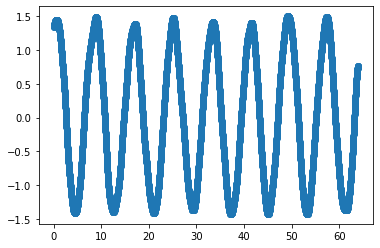

In [33]:
##### 特徴点データとゴニオデータの読み込み
print("###################  特徴点データとゴニオデータの読み込み  ###################")
print("EchoData: " + echo_file)
print("GonioData: " + gonio_file)

with open(fp_for_visualize_file_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    feature_points_for_visualize = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        feature_points_for_visualize.append(row)
    f.close()

feature_points_for_visualize = np.array(feature_points_for_visualize).astype(float)[:, :]

print("feature_points_for_visualize: ")
print(feature_points_for_visualize, feature_points_for_visualize.shape)
print("theta: ")
print(theta, theta.shape)

plt.scatter(time, theta)
# plt.show()
print("#####################################################################\n")

In [34]:
##### 選出した特徴点の描画・動画保存
print("###################  選出した特徴点の描画・動画保存  ###################")
# 特徴点データを元の形に直す（1つの特徴点につきx,y座標の2データを持つ）
feature_points_for_visualize = feature_points_for_visualize.reshape([feature_points_for_visualize.shape[0], feature_num, 2]) # (3212, 50, 2)
print("feature_points_for_visualize: ")
print(feature_points_for_visualize, feature_points_for_visualize.shape)

# 動画取得
video = cv2.VideoCapture(preprocessed_movie_path)

# 動画情報
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
size = (width, height)  # (right - left, 560)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = int(video.get(cv2.CAP_PROP_FPS))
print("FRAME COUNT: " + str(frame_count) + ",\nWIDTH: " + str(width) + ", HEIGHT: " + str(height) + "\n")

# 保存の準備
fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
save = cv2.VideoWriter(opticalflow_movie_file_path, fmt, frame_rate, size)

# 最初のフレームを取得
ret, frame = video.read()

# mask用の配列を生成
mask = np.zeros_like(frame)

# 最初の特徴点の座標を取得
points_pre = feature_points_for_visualize[0] # (50, 2)

# 動画終了まで繰り返し
for t in range(feature_points_for_visualize.shape[0] - 1):

    # 現在のフレームを取得
    ret, frame = video.read()
    if ret == False:
        print("false t: " + str(t))
        break

    # 現在の特徴点の座標を取得
    points_now = feature_points_for_visualize[t+1]

    # 現在の関節角度を取得
    theta_now = round(theta[t], 2)

    # オプティカルフローと現在の特徴点をmask, frameに描画
    for p_pre, p_now in zip(points_pre, points_now):
        x1, y1 = p_pre[0], p_pre[1]
        x2, y2 = p_now[0], p_now[1]

        mask = cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), [128, 128, 128], 1)
        frame = cv2.circle(frame, (int(x2), int(y2)), 5, [0, 0, 200], -1)

        # 関節角度情報を描画
        angle = "Wrist Angle: " + str(theta_now)
        # org = (20, 460) # 挿入する座標
        cv2.putText(frame, angle, wrist_angle_position, fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.5, color=(255, 255, 255))

    # frameとmaskの合成
    img = cv2.add(frame, mask)

    # ウィンドウに表示
    cv2.imshow("mask", img)

    # フレームごとに保存
    save.write(img)

    # 特徴点の更新
    points_pre = points_now

    # qキーが押されたら途中終了
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# 終了処理
cv2.destroyAllWindows()
video.release()
save.release()

print("Save completed")

# 特徴点データを解析用の形に戻す
feature_points_for_visualize = feature_points_for_visualize.reshape([feature_points_for_visualize.shape[0], feature_num * 2]) # (3212, 100)
print("#####################################################################\n")

###################  選出した特徴点の描画・動画保存  ###################
feature_points_for_visualize: 
[[[425.         191.        ]
  [889.         191.        ]
  [241.         186.        ]
  ...
  [177.         155.        ]
  [187.         157.        ]
  [793.         195.        ]]

 [[425.10064697 190.99902344]
  [889.05889893 191.10626221]
  [241.06666565 185.96150208]
  ...
  [176.97505188 154.93655396]
  [186.96980286 156.93759155]
  [793.01739502 195.05651855]]

 [[425.1668396  191.04205322]
  [889.14154053 191.15196228]
  [241.09214783 185.95339966]
  ...
  [177.05795288 154.88189697]
  [187.03895569 156.88829041]
  [793.00445557 195.09350586]]

 ...

 [[417.25537109 208.31163025]
  [863.71228027 169.02883911]
  [233.55467224 204.45591736]
  ...
  [141.32705688 160.21977234]
  [146.60220337 161.42114258]
  [770.98693848 188.29615784]]

 [[417.31143188 208.12042236]
  [864.36676025 168.97651672]
  [233.65275574 204.24424744]
  ...
  [141.85310364 160.19046021]
  [147.15048218 161.3805084

###################  特徴点データの処理・保存  ###################
EchoData: 20221206 162753.mp4

--Before Processing--


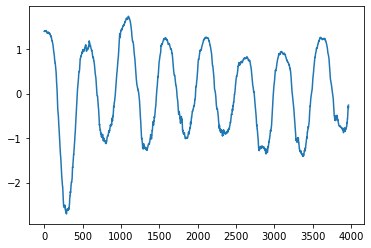

(3968, 50)
(3968,)

--After Processing--
processed_feature_points: 
[[ 0.63654735  1.03786564  0.73555219 ...  1.57143918  1.75243854
   1.39968359]
 [ 0.63949146  1.04053494  0.73824046 ...  1.57399467  1.75506702
   1.39984018]
 [ 0.64241502  1.04325105  0.74090822 ...  1.57655171  1.75769997
   1.39997967]
 ...
 [-0.06462154 -0.51283429 -0.04498246 ... -0.87949917 -0.9273972
  -0.44571093]
 [-0.06073489 -0.50699348 -0.04119993 ... -0.87290057 -0.92109268
  -0.44152176]
 [-0.05741988 -0.50203096 -0.0380361  ... -0.86728914 -0.91572741
  -0.43796731]] (3968, 50)
x: 
[0.00000000e+00 1.61330981e-02 3.22661961e-02 ... 6.39677338e+01
 6.39838669e+01 6.40000000e+01] (3968,)
y1: 
[ 0.63654735  0.63949146  0.64241502 ... -0.06462154 -0.06073489
 -0.05741988] (3968,)
y2: 
[ 0.63654735  0.63949146  0.64241502 ... -0.06462154 -0.06073489
 -0.05741988] (3968,)


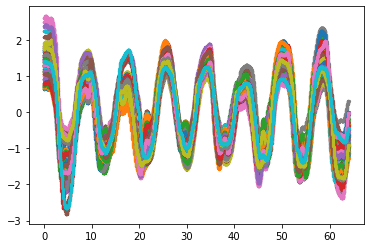

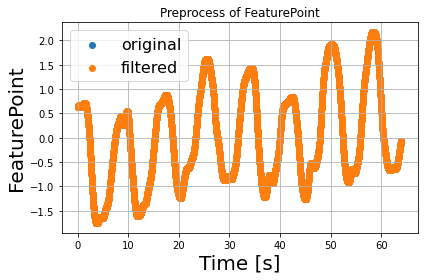

Save completed


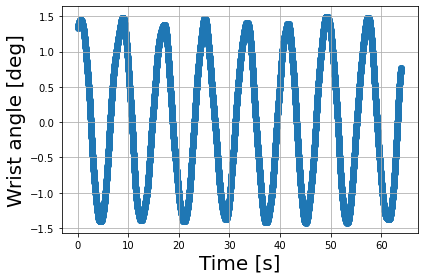

#####################################################################



In [35]:
##### 特徴点データの処理・保存
print("###################  特徴点データの処理・保存  ###################")
print("EchoData: " + echo_file)

print("\n--Before Processing--")
# print("feature_points: ")
# print(feature_points, feature_points.shape)

with open(fp_for_analysis_file_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    feature_points = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        feature_points.append(row)
    f.close()
feature_points = np.array(feature_points).astype(float)[:, :]

# 正規化
select_normalize_position = 2
#1:正規化しない、2:正規化する

if select_normalize_position==1:
    processed_feature_points = feature_points

if select_normalize_position==2:
  
    data_fp = feature_points
    processed_feature_points = feature_points

    #NumPyで配列の正規化(normalize)、標準化する方法
    #https://deepage.net/features/numpy-normalize.html
    import numpy as np
    def zscore(x, axis = None):
        xmean = x.mean(axis=axis, keepdims=True)
        xstd  = np.std(x, axis=axis, keepdims=True)
        zscore = (x-xmean)/xstd
        return zscore, xmean, xstd

    #すべての特徴点の正規化
    for i in range(data_fp.shape[1]):
        fp_part,fp_mean,fp_std = zscore(data_fp[:,i])
        processed_feature_points[:,i] = fp_part

    plt.plot(fp_part)
    plt.show()

    print('===============')
    print(feature_points.shape)
    print(fp_part.shape)
    print('===============')
    

# # ローパスフィルタ
# #フィルター選択(角度情報)
# #1: raw, 2:lowpath
# lowpass_filter_pattern = 1

#ローパス
samplerate = 30
fp_l = 0.5 # 通過域端周波数[Hz] #フーリエ変換にあわせて調整
fs_l = 2.5 # 阻止域端周波数[Hz] # fp*5くらい
gpass_l = 3 # 通過域端最大損失[dB]
gstop_l = 40 # 阻止域端最小損失[dB]
from scipy import signal
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y  

if lowpass_filter_pattern == 2:
    for i in range(data_fp.shape[1]):
        fp_part,fp_mean,fp_std = zscore(processed_feature_points[:,i])
        fp_part_low = lowpass(fp_part, samplerate, fp_l, fs_l, gpass_l, gstop_l)
        plt.scatter(time,fp_part_low,s=5)

        processed_feature_points[:,i] = fp_part_low


# 特徴点データを保存
with open(filtered_fp_file_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Processed Feature Points Data"])
    for each_time_data in processed_feature_points:
        writer.writerow(each_time_data)
    f.close()
    

print("\n--After Processing--")
print("processed_feature_points: ")
print(processed_feature_points, processed_feature_points.shape)


# 比較グラフの表示・保存（Noつ目の特徴点のみ）
No = 0
x = time
y1 = feature_points[:, No]
y2 = processed_feature_points[:, No]

print("x: ")
print(x, x.shape)
print("y1: ")
print(y1, y1.shape)
print("y2: ")
print(y2, y2.shape)

fig = plt.figure()
plt.title("Preprocess of FeaturePoint")
plt.scatter(x, y1, label='original')
plt.scatter(x, y2, label='filtered')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("FeaturePoint", fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
fig.savefig(echo_raw_vs_filtered_file_path)

print("Save completed")

plt.scatter(time, theta)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()
print("#####################################################################\n")

In [36]:
print("################################################################")
print("#######################  解析  ############################")
print("################################################################")

################################################################
#######################  解析  ############################
################################################################


In [37]:
##### 結果保存用パス設定
print("###################  結果保存用パス設定  ###################")
fp_behavior_file_path = analysis_path + "/Results/FPBehavior/" + gonio_file.split(".")[0]
angle_estimation = analysis_path + "/Results/AngleEstimation/" + gonio_file.split(".")[0]
print("#####################################################################\n")

###################  結果保存用パス設定  ###################
#####################################################################



In [38]:
##### データ読み込み
print("###################  データ読み込み  ###################")
print("EchoData : " + echo_file)
print("GonioData: " + gonio_file)

with open(filtered_fp_file_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    X = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        X.append(row)
    f.close()

X = np.array(X).astype(float)[:, :]
theta = np.array(theta).astype(float)[:, np.newaxis]

print("X: ")
print(X, X.shape)
print("theta: ")
print(theta, theta.shape)
print("#####################################################################\n")

###################  データ読み込み  ###################
EchoData : 20221206 162753.mp4
GonioData: 202212061627.csv
X: 
[[ 0.63654735  1.03786564  0.73555219 ...  1.57143918  1.75243854
   1.39968359]
 [ 0.63949146  1.04053494  0.73824046 ...  1.57399467  1.75506702
   1.39984018]
 [ 0.64241502  1.04325105  0.74090822 ...  1.57655171  1.75769997
   1.39997967]
 ...
 [-0.06462154 -0.51283429 -0.04498246 ... -0.87949917 -0.9273972
  -0.44571093]
 [-0.06073489 -0.50699348 -0.04119993 ... -0.87290057 -0.92109268
  -0.44152176]
 [-0.05741988 -0.50203096 -0.0380361  ... -0.86728914 -0.91572741
  -0.43796731]] (3968, 50)
theta: 
[[1.33748309]
 [1.34219096]
 [1.34690571]
 ...
 [0.76053191]
 [0.76357821]
 [0.7661249 ]] (3968, 1)
#####################################################################



In [39]:
##### 学習データ・テストデータの分割
print("###################  学習データ・テストデータの分割  ###################")
# 訓練データとテストデータの区切り位置
devide_prop = 3 / 4
devide_num = round(X.shape[0] * devide_prop)

print("devide_prop: " + str(devide_prop))
print("devide_num: " + str(devide_num))

X_train = X[:devide_num]
theta_train = theta[:devide_num]

print("devide_num: " + str(devide_num))
print("X_train: ")
print(X_train, X_train.shape)
print("theta_train: ")
print(theta_train, theta_train.shape)
print("#####################################################################\n")

###################  学習データ・テストデータの分割  ###################
devide_prop: 0.75
devide_num: 2976
devide_num: 2976
X_train: 
[[ 6.36547350e-01  1.03786564e+00  7.35552188e-01 ...  1.57143918e+00
   1.75243854e+00  1.39968359e+00]
 [ 6.39491461e-01  1.04053494e+00  7.38240465e-01 ...  1.57399467e+00
   1.75506702e+00  1.39984018e+00]
 [ 6.42415025e-01  1.04325105e+00  7.40908216e-01 ...  1.57655171e+00
   1.75769997e+00  1.39997967e+00]
 ...
 [ 1.53985421e-01 -1.96845990e-02  6.52281776e-01 ...  3.15270407e-01
   3.79223966e-01 -4.07529598e-01]
 [ 1.81614209e-01  1.04722339e-03  6.65955394e-01 ...  3.38339948e-01
   4.02128807e-01 -3.80607223e-01]
 [ 2.09784756e-01  2.19822211e-02  6.79831662e-01 ...  3.61029318e-01
   4.24699991e-01 -3.53434681e-01]] (2976, 50)
theta_train: 
[[1.33748309]
 [1.34219096]
 [1.34690571]
 ...
 [0.87765975]
 [0.88955991]
 [0.90141563]] (2976, 1)
#####################################################################



In [40]:
##### 重みの導出
print("###################  重みの導出  ###################")
# #最小事情法で正則化するか
# #1:正則化なし、2:正則化あり
# regularization_pattern = 2

X_T = X_train.T
X_T_X = np.dot(X_T, X_train)
I = np.eye(X_T_X.shape[0])

if regularization_pattern==1:
    inv = np.linalg.pinv(X_T_X)

if regularization_pattern==2:
    inv = np.linalg.pinv(X_T_X + lam * I)

W = np.dot(np.dot(inv, X_T), theta_train)

W_reshape = W.reshape(-1)
W_max_index = np.argmax(W_reshape)
W_max = np.max(W_reshape)
W_min_index = np.argmin(W_reshape)
W_min = np.min(W_reshape)

print("X_T: " + str(X_T.shape))
print("X_T_X: " + str(X_T_X.shape))
print("inv: " + str(inv.shape))
print("W: " + str(W.shape))
# print(W)
print("W_max: ")
print("index: " + str(W_max_index) + " value: " + str(W_max))
print("W_min: ")
print("index: " + str(W_min_index) + " value: " + str(W_min))
print("#####################################################################\n")

###################  重みの導出  ###################
X_T: (50, 2976)
X_T_X: (50, 50)
inv: (50, 50)
W: (50, 1)
W_max: 
index: 44 value: 1.619117743359414
W_min: 
index: 46 value: -1.7075096314610898
#####################################################################



###################  関節角度-特徴点座標のグラフを作成・保存  ###################
angle: 
(3968,)
X_max: 
(3968,)
X_min: 
(3968,)


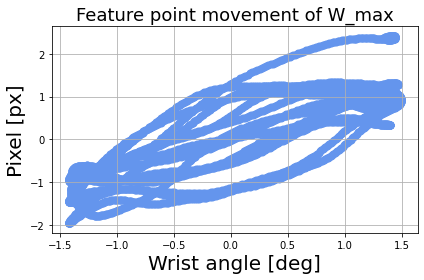

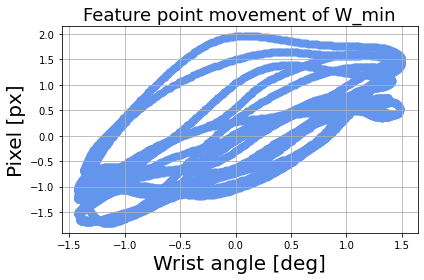

Save completed
#####################################################################



In [41]:
##### 関節角度-特徴点座標のグラフを作成・保存
print("###################  関節角度-特徴点座標のグラフを作成・保存  ###################")
angle = theta.reshape(-1)
# 重みが最大・最小となっている特徴点のみ取り出す
X_max = X[:, W_max_index]
X_min = X[:, W_min_index]

print("angle: ")
print(angle.shape)
print("X_max: ")
print(X_max.shape)
print("X_min: ")
print(X_min.shape)

def Visualize(x, y, save_path, max_or_min):
    fig = plt.figure()
    plt.title("Feature point movement of W_" + max_or_min, fontsize=18)
    plt.xlabel("Wrist angle [deg]", fontsize=20)
    plt.ylabel("Pixel [px]", fontsize=20)
    plt.scatter(x, y, color="cornflowerblue", linewidth=2, label="Feature Point Movement")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    fig.savefig(save_path + max_or_min + ".png")
    plt.close()

Visualize(angle, X_max, fp_behavior_file_path, "max")
Visualize(angle, X_min, fp_behavior_file_path, "min")

print("Save completed")
print("#####################################################################\n")

In [42]:
##### 関節角度の推定値を導出
print("###################  関節角度の推定値を導出  ###################")
theta_pred = np.dot(X, W)

print("theta_pred: ")
print(theta_pred, theta_pred.shape)
print("#####################################################################\n")

###################  関節角度の推定値を導出  ###################
theta_pred: 
[[ 1.30102946]
 [ 1.3052972 ]
 [ 1.30955221]
 ...
 [-0.62088645]
 [-0.61862803]
 [-0.6167176 ]] (3968, 1)
#####################################################################



###################  グラフ作成・保存  ###################
x: 
[0.00000000e+00 1.61330981e-02 3.22661961e-02 ... 6.39677338e+01
 6.39838669e+01 6.40000000e+01] (3968,)
y1: 
[1.33748309 1.34219096 1.34690571 ... 0.76053191 0.76357821 0.7661249 ] (3968,)
y2: 
[ 1.30102946  1.3052972   1.30955221 ... -0.62088645 -0.61862803
 -0.6167176 ] (3968,)


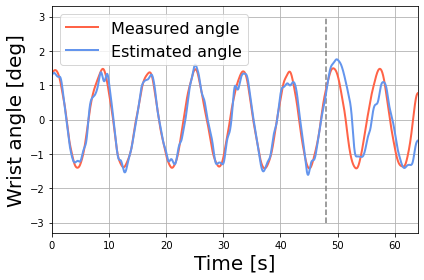

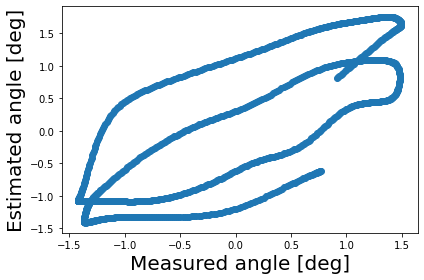

#####################################################################



In [43]:
##### グラフ作成・保存
print("###################  グラフ作成・保存  ###################")
x = time
y1 = theta.reshape(-1)
y2 = theta_pred.reshape(-1)

print("x: ")
print(x, x.shape)
print("y1: ")
print(y1, y1.shape)
print("y2: ")
print(y2, y2.shape)

fig1 = plt.figure()
# plt.title("A result of estimating wrist joint angle", fontsize=18)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.plot(x, y1, color="tomato", linewidth=2, label="Measured angle")
plt.plot(x, y2, color="cornflowerblue", linewidth=2, label="Estimated angle")
line_position = devide_num / echo_frame_rate

#plt.vlines(line_position, min_height, max_height, "gray", linestyles="dashed")
plt.vlines(line_position, -3, 3, "gray", linestyles="dashed")

#plt.ylim(min_height, max_height) #extensor

plt.xlim(0, x.shape[0] / echo_frame_rate)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
fig1.savefig(angle_estimation + "_estimation.png")

fig2 = plt.figure()
# plt.title("Scatter plots of estimated and measured angle", fontsize=16)
plt.xlabel("Measured angle [deg]", fontsize=20)
plt.ylabel("Estimated angle [deg]", fontsize=20)
plt.scatter(y1[devide_num:], y2[devide_num:])
plt.tight_layout()
fig2.savefig(angle_estimation + "_scatter.png")

plt.show()
plt.close()
print("#####################################################################\n")

In [44]:
##### RMSE，決定係数R2，相関係数coeffを導出
print("###################  RMSE，決定係数R2，相関係数coeffを導出  ###################")
theta_test = theta.reshape(-1)[devide_num:]
theta_pred_test = theta_pred.reshape(-1)[devide_num:]

T = theta_test.shape[0]
L = np.sum((theta_test - theta_pred_test)**2)
RMSE = np.sqrt(L/T)


if select_normarize_joint == 2:
    RMSE = float(theta_std*RMSE)

R2 = r2_score(theta_test, theta_pred_test)

coef = np.corrcoef(theta_test, theta_pred_test)[0][1]

print("theta_test: ")
print(theta_test.shape)
print("theta_pred_test: ")
print(theta_pred_test.shape)
print("T: " + str(T))
print("L: " + str(L))
print("RMSE: " + str(RMSE))
    
print("決定係数 R2: " + str(R2))
print("相関係数: " + str(coef) + "\n")
print("#####################################################################\n")

###################  RMSE，決定係数R2，相関係数coeffを導出  ###################
theta_test: 
(992,)
theta_pred_test: 
(992,)
T: 992
L: 457.66233688073703
RMSE: 13.6709664605104
決定係数 R2: 0.5603140097577237
相関係数: 0.7875701128541457

#####################################################################



In [45]:
##### 結果の保存
print("###################  結果の保存  ###################")
### datasheet_all.csvへの書き込み
# 結果の更新
target_df.loc[data_No, ["RMSE"]] = RMSE
target_df.loc[data_No, ["R2"]] = R2
target_df.loc[data_No, ["Corrcoef"]] = coef
target_df.loc[data_No, ["Updated Date"]] = updated_date

print("-------------  target_df  ---------------------")
print(target_df)
print("-----------------------------------------------")

# datasheet_all.csv用のデータフレームを更新
datasheet_all_df.update(target_df)

# datasheet_all.csvに書き込み
datasheet_all_df.to_csv(datasheet_all_path, encoding="shift_jis")


### datasheet_per_info.csvへの書き込み

## target_per_info_dfが空の場合
if target_per_info_df.empty:
    new_data_per_info = [(per_info_No, data_No, gonio_file, echo_file, date, subject, pattern, trial_num, depth, analysis_num, 
                fp_selection_pattern, fp_num_pattern, fp_detection_pattern, frame_range_pattern, lowpass_filter_pattern, regularization_pattern, 
                RMSE, R2, coef, updated_date)]
    new_df_per_info = pd.DataFrame(data=new_data_per_info, columns=cols_per_info)
    new_df_per_info.set_index("Per Info No", inplace=True)
    print("-------------  new_df_per_info  ---------------------")
    print(new_df_per_info)
    print("-----------------------------------------------------")

    # datasheet_per_info.csvに書き込み
    datasheet_per_info_df = datasheet_per_info_df.append(new_df_per_info)
    datasheet_per_info_df.to_csv(datasheet_per_info_path, encoding="shift_jis")
    
## target_per_info_dfが空でない場合
else:
    # 結果の更新
    target_per_info_df.loc[per_info_No, ["RMSE"]] = RMSE
    target_per_info_df.loc[per_info_No, ["R2"]] = R2
    target_per_info_df.loc[per_info_No, ["Corrcoef"]] = coef
    target_per_info_df.loc[per_info_No, ["Updated Date"]] = updated_date

    print("-------------  target_per_info_df  ---------------------")
    print(target_per_info_df)
    print("--------------------------------------------------------")

    # datasheet_per_info.csv用のデータフレームを更新
    datasheet_per_info_df.update(target_per_info_df)

    # datasheet_per_info.csvに書き込み
    datasheet_per_info_df.to_csv(datasheet_per_info_path, encoding="shift_jis")


print("Save completed")
print("#####################################################################\n")

###################  結果の保存  ###################
-------------  target_df  ---------------------
                    Gonio                 Echo        Date Subject  Pattern  \
Data No                                                                       
20       202212061627.csv  20221206 162753.mp4  20221204.0  Katagi      1.0   

         Trial Num  Depth       RMSE        R2  Corrcoef      Updated Date  
Data No                                                                     
20             5.0   30.0  13.670966  0.560314   0.78757  2022/12/12 02:08  
-----------------------------------------------
-------------  new_df_per_info  ---------------------
             Data No             Gonio                 Echo      Date Subject  \
Per Info No                                                                     
5                 20  202212061627.csv  20221206 162753.mp4  20221204  Katagi   

             Pattern  Trial Num  Depth  Analysis Num  FP Selection Pattern  \
Per Info No